In [23]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import esda
import pysal as ps
from pysal.lib import weights
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation

import libpysal
from libpysal.weights import Queen, Rook, KNN

In [2]:
tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}
from matplotlib import rcParams
rcParams['font.family'] = 'Liberation Sans Narrow'

In [3]:
msoa_cropped = gpd.read_file('../data/output.msoa_cropped.geojson')

In [4]:
# msoa_cropped_v2.to_file('../data/output.msoa_cropped_v2.geojson', driver='GeoJSON')
msoa_cropped_v2 = gpd.read_file('../data/output.msoa_cropped_v2.geojson')
msoa_cropped_v2 = msoa_cropped_v2[['MSOA11CD', 'MSOA11NM','geometry']]

In [5]:
bus_msoa = pd.read_csv('../data/y/bus_msoa.csv')
bus_msoa_gdf = msoa_cropped_v2.merge(bus_msoa, how='left')

In [6]:
c_arr_msoa = pd.read_csv('../data/y/c_arr_msoa.csv')
c_arr_msoa_gdf = msoa_cropped_v2.merge(c_arr_msoa, how='left')

### Weights

In [7]:
wq = Queen.from_dataframe(msoa_cropped_v2)

/opt/conda/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [8]:
wq.pct_nonzero

3.1792882442233092

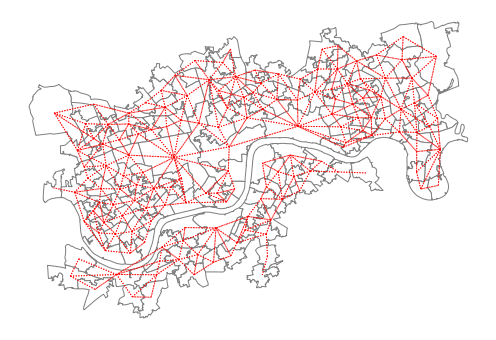

In [143]:
msoa_cropped_v2 = msoa_cropped_v2.to_crs('epsg:27700')

ax = msoa_cropped_v2.plot(edgecolor='grey', facecolor='w', figsize=(10,6))
f,ax = wq.plot(msoa_cropped_v2, ax=ax,
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

In [125]:
# wq.neighbors

In [9]:
wq.transform = 'R'

In [134]:
w = weights.distance.KNN.from_dataframe(bus_msoa_gdf, k=8)
# Row-standardization
w.transform = 'R'

In [13]:
moran = esda.moran.Moran(bus_msoa_gdf['b_passengers201906'], wq)
print(round(moran.I,3))
print(round(moran.p_sim,3))

0.222
0.001


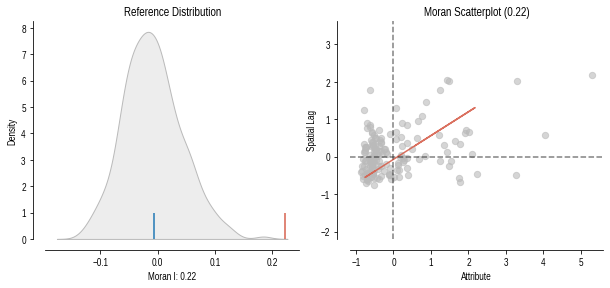

In [15]:
from splot.esda import plot_moran
plot_moran(moran);

In [18]:
moran = esda.moran.Moran(bus_msoa_gdf['b_passengers202006'], wq)
print(round(moran.I,3))
print(round(moran.p_sim,3))

0.151
0.006


In [17]:
moran = esda.moran.Moran(bus_msoa_gdf['b_passengers202106'], wq)
print(round(moran.I,3))
print(round(moran.p_sim,3))

0.219
0.004


In [31]:
moran = esda.moran.Moran(c_arr_msoa_gdf['c_trips201906'], wq)
print(round(moran.I,3))
print(round(moran.p_sim,3))

0.383
0.001


In [30]:
moran = esda.moran.Moran(c_arr_msoa_gdf['c_trips202006'], wq)
print(round(moran.I,3))
print(round(moran.p_sim,3))

0.362
0.001


In [29]:
moran = esda.moran.Moran(c_arr_msoa_gdf['c_trips202106'], wq)
print(round(moran.I,3))
print(round(moran.p_sim,3))

0.407
0.001


### Local Moran's I

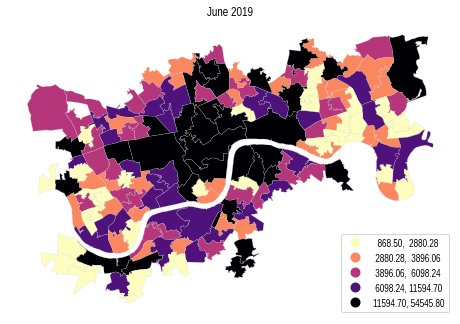

In [35]:
ax = bus_msoa_gdf.plot(figsize=(8,6), column='b_passengers201906', cmap = 'magma_r',
                      edgecolor='lightgrey', linewidth = 0.2, legend=True, legend_kwds=dict(loc=4),
                  scheme='quantiles', k=5)
ax.axis('off')
ax.set_title("June 2019");

In [293]:
bus_msoa_gdf['w_b_passengers201906'] = weights.spatial_lag.lag_spatial(wq, bus_msoa_gdf['b_passengers201906'])

In [294]:
bus_msoa_gdf['b_201906_std'] = ( bus_msoa_gdf['b_passengers201906'] - bus_msoa_gdf['b_passengers201906'].mean() )\
                    / bus_msoa_gdf['b_passengers201906'].std()
bus_msoa_gdf['w_b_201906_std'] = ( bus_msoa_gdf['w_b_passengers201906'] - bus_msoa_gdf['b_passengers201906'].mean() )\
                    / bus_msoa_gdf['b_passengers201906'].std()

In [295]:
bus_msoa_gdf.head(2)

,MSOA11CD,MSOA11NM,geometry,b_passengers201906,b_passengers202006,b_passengers202106,w_b_passengers201906,b_201906_std,w_b_201906_std,Is
0,E02000001,City of London 001,"POLYGON ((-0.09650 51.52295, -0.09644 51.52282...",43690.9,11964.875,33398.250,13423.78,4.041269,0.579072,2.269374
1,E02000180,Camden 015,"POLYGON ((-0.12745 51.54793, -0.12726 51.54775...",3913.1,1347.625,2538.125,13442.70,-0.508836,0.581236,-0.221422


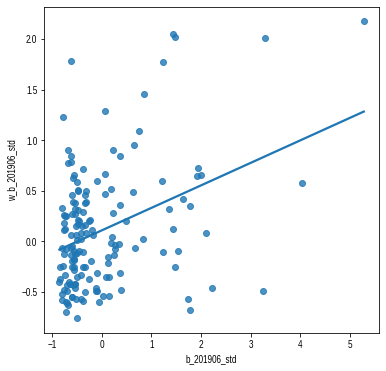

In [296]:
f, ax = plt.subplots(1, figsize=(6, 6))

sns.regplot(x='b_201906_std', y='w_b_201906_std', data=bus_msoa_gdf, ci=None)

plt.show()

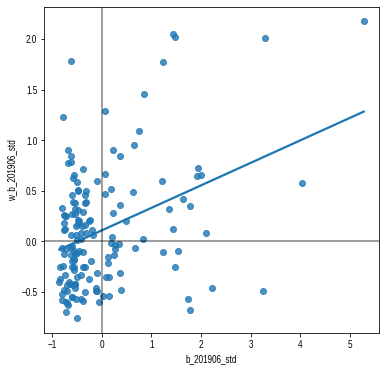

In [297]:
f, ax = plt.subplots(1, figsize=(6, 6))

sns.regplot(x='b_201906_std', y='w_b_201906_std', data=bus_msoa_gdf, ci=None)

# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)

# plt.text(1, 1.5, "HH", fontsize=25)
# plt.text(1, -1.5, "HL", fontsize=25)
# plt.text(-1.5, 1.5, "LH", fontsize=25)
# plt.text(-1.5, -1.5, "LL", fontsize=25)

plt.show()

In [37]:
lisa = esda.moran.Moran_Local(bus_msoa_gdf['b_passengers201906'], wq)

<AxesSubplot:ylabel='Density'>

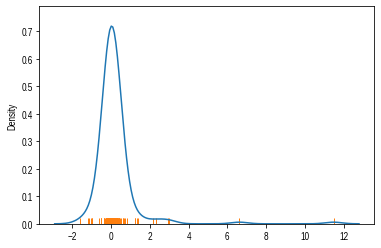

In [299]:
ax = sns.kdeplot(lisa.Is)
sns.rugplot(lisa.Is, ax=ax)

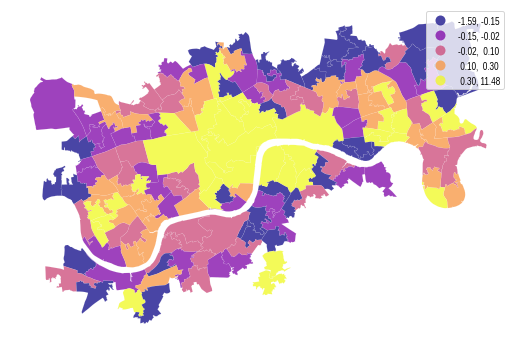

In [300]:
f, ax = plt.subplots(1, figsize=(9,9))
bus_msoa_gdf['Is'] = lisa.Is
bus_msoa_gdf.plot(column='Is', cmap='plasma', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True,ax=ax);

ax.set_axis_off()

In [62]:
c_arr_msoa_gdf['c_trips202106'] = c_arr_msoa_gdf['c_trips202106'].fillna(0)
lisa = esda.moran.Moran_Local(c_arr_msoa_gdf['c_trips202106'], wq)
c_arr_msoa_gdf['Is'] = lisa.Is

In [61]:
c_arr_msoa_gdf

,MSOA11CD,MSOA11NM,geometry,c_trips201906,c_trips202006,c_trips202106,Is
0,E02000001,City of London 001,"POLYGON ((-0.09650 51.52295, -0.09644 51.52282...",1582.400,1556.111111,1770.500,NaN
1,E02000180,Camden 015,"POLYGON ((-0.12745 51.54793, -0.12726 51.54775...",27.625,62.444444,38.250,NaN
2,E02000183,Camden 018,"POLYGON ((-0.14472 51.54502, -0.14481 51.54500...",118.900,215.777778,179.375,NaN
3,E02000184,Camden 019,"POLYGON ((-0.14151 51.54500, -0.14150 51.54493...",159.900,276.888889,136.375,NaN
4,E02000186,Camden 021,"POLYGON ((-0.14328 51.54220, -0.14323 51.54206...",288.600,472.111111,414.875,NaN
...,...,...,...,...,...,...,...
149,E02000983,Westminster 024,"MULTIPOLYGON (((-0.14924 51.48553, -0.14998 51...",150.600,269.111111,237.750,NaN
150,E02006801,Lambeth 036,"POLYGON ((-0.10890 51.50843, -0.10881 51.50792...",1456.900,1335.888889,1841.250,NaN
151,E02006802,Southwark 034,"POLYGON ((-0.10451 51.50461, -0.10452 51.50437...",296.100,404.444444,469.750,NaN
152,E02006853,Tower Hamlets 032,"POLYGON ((-0.01886 51.50044, -0.01857 51.50040...",43.100,169.111111,80.500,NaN


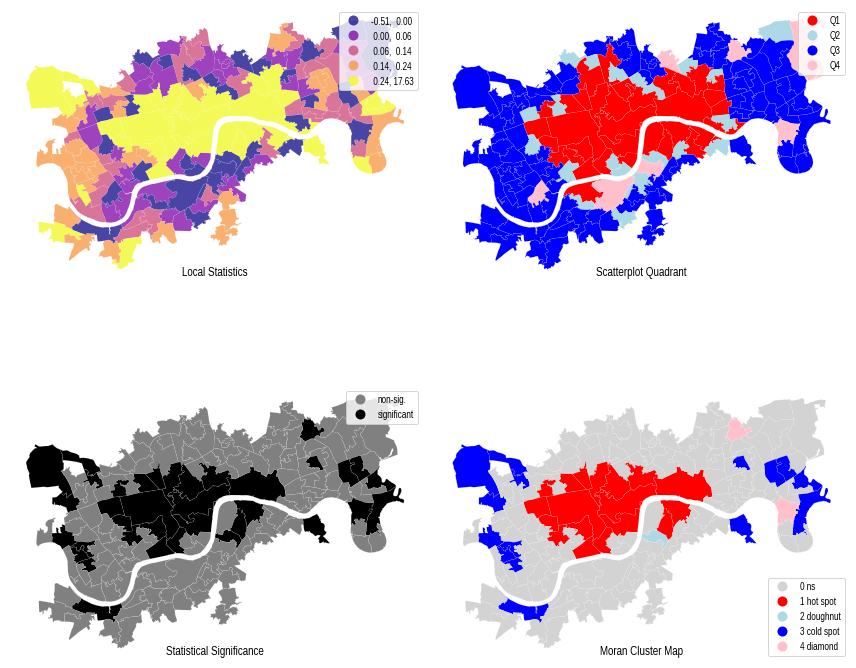

In [63]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
ax = axs[0]
c_arr_msoa_gdf.plot(column='Is', cmap='plasma', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True, ax=ax)

                    # Subplot 2 #
ax = axs[1]
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels = [q_labels[i-1] for i in lisa.q]
hmap = colors.ListedColormap([ 'red', 'lightblue', 'blue', 'pink'])
c_arr_msoa_gdf.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

                    # Subplot 3 #

ax = axs[2]
sig = 1 * (lisa.p_sim < 0.05)
hmap = colors.ListedColormap(['grey','black'])
labels = ['non-sig.', 'significant'] 
labels = [labels[i] for i in sig]
c_arr_msoa_gdf.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

                       
                    # Subplot 4 #
ax = axs[3]
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])

c_arr_msoa_gdf.assign(cl=labels).plot(column='cl', categorical=True,
        k=2, cmap=hmap, linewidth=0.1, ax=ax,
        edgecolor='white', legend_kwds=dict(loc=4), legend=True)

for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(['Local Statistics', 
                  'Scatterplot Quadrant', 
                  'Statistical Significance', 
                  'Moran Cluster Map'][i], y=0)

f.tight_layout()

# Display the figure
plt.show()

### Replicate for all layers

In [24]:
def get_lisa_map(gdf, var_col, output_name):
    gdf[var_col] = gdf[var_col].fillna(0)
    lisa = esda.moran.Moran_Local(gdf[var_col], wq)
    gdf['Is'] = lisa.Is
    sig = 1 * (lisa.p_sim < 0.05)
    hotspot = 1 * (sig * lisa.q==1)
    coldspot = 3 * (sig * lisa.q==3)
    doughnut = 2 * (sig * lisa.q==2)
    diamond = 4 * (sig * lisa.q==4)
    spots = hotspot + coldspot + doughnut + diamond
#     spot_labels = [ '0 Not significant', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
    spot_labels = ['0 Not significant', '1 High-high', '2 Low-high', '3 Low-low', '4 High-low']
    labels = [spot_labels[i] for i in spots]
    hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
    
    fig, ax = plt.subplots(figsize=(10,6))
    gdf.assign(cl=labels).plot(column='cl', categorical=True,
        k=2, cmap=hmap, linewidth=0.1, ax=ax,
        edgecolor='white', legend_kwds=dict(loc=4), legend=True)
    
#     ctx.add_basemap(ax, 
# #                        crs=gdf.crs, 
# #                        source=ctx.providers.Stamen.TerrainBackground,
#                        crs=gdf.crs, source=ctx.providers.CartoDB.PositronNoLabels)

    ax.set_axis_off()
#     ax.set_title('Moran Cluster Map')
#     fig.savefig('../output/' + output_name)

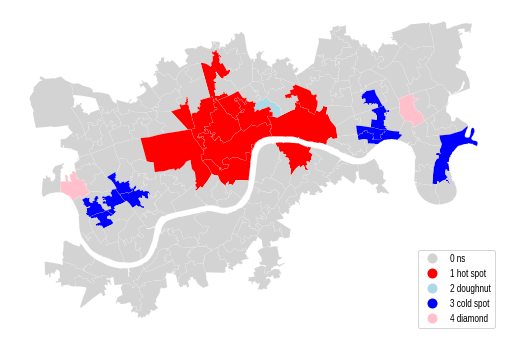

In [40]:
get_lisa_map(bus_msoa_gdf, 'b_passengers201906', 'b_moran_map_201906')

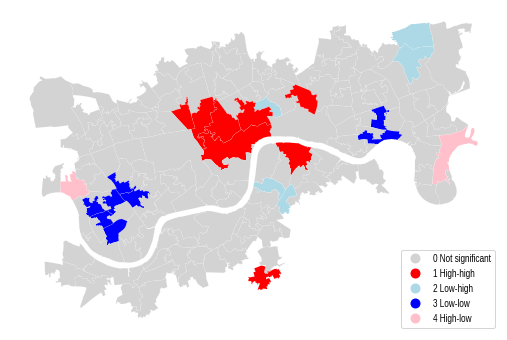

In [303]:
get_lisa_map(bus_msoa_gdf, 'b_passengers202006', 'b_moran_map_202006')

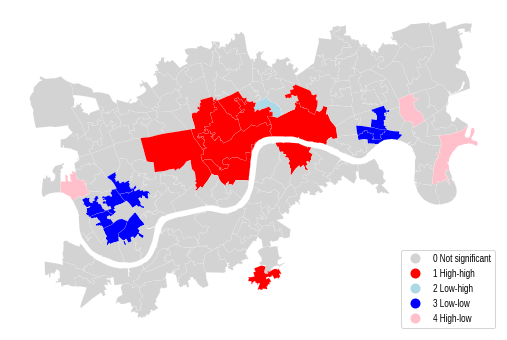

In [304]:
get_lisa_map(bus_msoa_gdf, 'b_passengers202106', 'b_moran_map_202106')

### Cycling

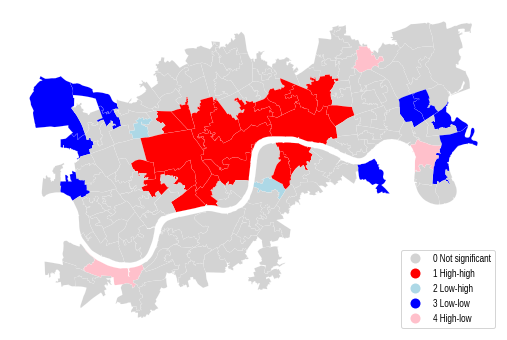

In [25]:
get_lisa_map(c_arr_msoa_gdf, 'c_trips201906', 'c_moran_map_201906')

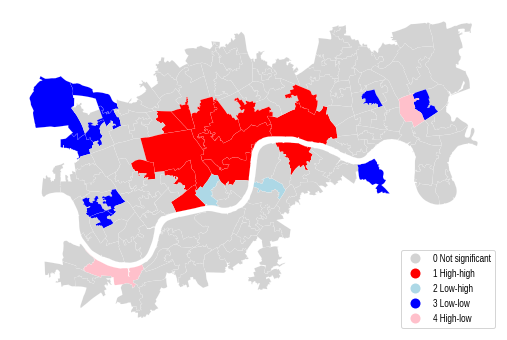

In [26]:
get_lisa_map(c_arr_msoa_gdf, 'c_trips202006', 'c_moran_map_202006')

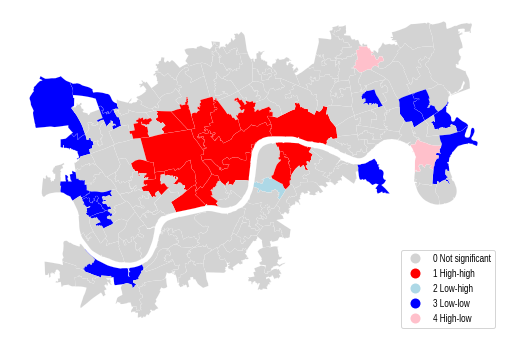

In [27]:
get_lisa_map(c_arr_msoa_gdf, 'c_trips202106', 'c_moran_map_202106')